<a href="https://colab.research.google.com/github/DomenicoArmillotta/ImageClassification-OCT/blob/main/OCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ISSUE (READ BEFORE)** : 

The main problem encountered, that keras is used for small datasets, is it has much lower performance than tensorflow or pyTorch.
This is why the training took too long, so for an implementation of a problem with real objects and images, it is not advisable to use the keras framework.
Here you can see the benchmarks between pyTorch and keras (https://wrosinski.github.io/deep-learning-speed-vol1/).
So it was decided to switch to pyTorch , to implement models with a framework also used in research and corporate. 
keras has the characteristic of being easier to use and organise, but given its low performance, being a high-level framework, we were forced to change the framework.
That is why the explainability and the various tests of the written architectures were not continued.
The report below will describe the work done in the first moments, up to the interruption. The report and all the precautions taken with regard to the code have been scrupulously reviewed, trying to bring the keras framework to its full potential. 
Work has not been interrupted, but implementations using pyTorch will appear in the near future.

Cose da fare e/o controllare : 

*  FARE  Test
* provare con le pre trainate : inceptionv3 , mobilenet
* capire se va meglio dopo aver fatto rescale 1/255

https://www.tensorflow.org/tutorials/load_data/images?hl=it

**Feature reuse** : 
This approach is typically used when the data and task being tackled are very different from the original task the pre-trained model was trained on.

**Fine-tuning** : 
 This approach is typically used when the data and task being tackled are similar to the original task the pre-trained model was trained on


[Dataset link](https://www.kaggle.com/datasets/paultimothymooney/kermany2018)

**Pay Attention** : Is used an organization of the code made to easy run the code to train

**Resume risultati :**
1. Mnist --> 75% ma overfitting    5 epoche
2. Alexnet --> 60%     1 epoca
3. Efficent net --> 35%   5 epoche
4. Inception --> 77%     3.5 epoche

# **Library + Class weight**

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Dropout
from sklearn.metrics import accuracy_score
np.random.seed(42)
from google.colab import drive

from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Activation, add, Add, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras import optimizers

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input


Distribution of the class inside the folder , without using np array

is pretty fast --> 5s


In [ ]:
# setup directory used in the project for training and test phase
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/dataset/OCT/'
train_dir = '/content/drive/MyDrive/dataset/OCT/train'
test_dir = '/content/drive/MyDrive/dataset/OCT/test'
val_dir = '/content/drive/MyDrive/dataset/OCT/val'

Mounted at /content/drive


In [ ]:
#compute class weight train for inbalanced dataset --> estimated time for 80k documents = 3s

import pathlib

# create array with all classes in the train
summary = pd.DataFrame()
val_classes = [item.name for item in 
                 pathlib.Path('/content/drive/MyDrive/dataset/OCT/train').glob('*')]

# count the number of files in each folder
# print(val_classes)
for d in ['train']:
    for c in val_classes:
        n = len([i for i in pathlib.Path(f'/content/drive/MyDrive/dataset/OCT/{d}/{c}').glob('*')])
        summary.loc[c, d] = n
summary.style.format("{:.0f}")




Compue class_weights

In [ ]:
train_directory = '/content/drive/MyDrive/dataset/OCT/train/'

# ['DME', 'CNV', 'NORMAL', '.DS_Store', 'DRUSEN']
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                label = 4
            for image_filename in tqdm(os.listdir(folder + folderName)):
                y.append(label)
    y = np.asarray(y)
    return y
y_train= get_data(train_directory)


from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 4)

from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(y_train),y =  y_train)
class_weights = dict(zip(np.unique(y_train), class_weight))
class_weights


In [ ]:


# Initializing a dictionary with values
class_weights = {0: '0.7932072962188865', 1: '0.5608977804052239', 2: '1.839376982728234', 3: '2.4226149025069637'}

{0: 0.7932072962188865,
 1: 0.5608977804052239,
 2: 1.839376982728234,
 3: 2.4226149025069637}

# **1. ALEXNET from scratch**

In [ ]:
# setup directory used in the project for training and test phase
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/dataset/OCT/'
train_dir = '/content/drive/MyDrive/dataset/OCT/train'
test_dir = '/content/drive/MyDrive/dataset/OCT/test'
val_dir = '/content/drive/MyDrive/dataset/OCT/val/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',  #greyscale = 1 channel image
    batch_size=128,          
    image_size=(50, 50),     #qui le dim dell'immagine , da esperimenti risulta che se cambiamo a 150 non cambia troppo il tempo di train
    shuffle=True,
    seed=None,
    validation_split=None,  #abbiamo gia il validation set
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)



val = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=128,
    image_size=(50, 50),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)






In [ ]:
#usato per la normalizzazzione -> lo fa keras negli esempi -> velocizza il training
normalization_layer = tf.keras.layers.Rescaling(1./255)    
val = val.map(lambda x, y: (normalization_layer(x), y))
train = train.map(lambda x, y: (normalization_layer(x), y))


In [ ]:
# mantiene le immagini in memoria dopo che sono state caricate dal disco durante la prima epoca. Velocizza il training
#lo fa keras negli esempi
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Early stopping -> sistemata
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=7,
    mode='auto',
    restore_best_weights=True)

In [ ]:
img_size = 50
model = keras.models.Sequential()
#1st Convolutional Layer
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', input_shape = [img_size, img_size,1]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#2nd Convolutional Layer
model.add(keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#3rd Convolutional Layer
model.add(keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#4th Convolutional Layer
model.add(keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#Passing it to a Fully Connected layer
model.add(keras.layers.Flatten())

# 1st Fully Connected Layer
model.add(keras.layers.Dense(512,activation='relu'))

# 2st Fully Connected Layer
model.add(keras.layers.Dense(512,activation='relu'))

#Softmax layer for output
model.add(keras.layers.Dense(4,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 22, 22, 64)       2

### Training **Senza** Augmentation

In [ ]:

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(train, epochs=12, validation_data=val ,steps_per_epoch=150 , verbose = 1 , callbacks=[early_stopping] , class_weight = class_weights)


Epoch 1/12
 68/150 [============>.................] - ETA: 36:44 - loss: 1.3959 - accuracy: 0.6013

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/MyDrive/model/AlexNet_noAUG.h5')   # always save your weights after training or during training
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
#disconnessione per non consumare risorse
from google.colab import runtime
runtime.unassign()

### Training **Con** Augmentation

In [ ]:
#Augmentation --> farlo con il layer
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

img_height = 50
batch_size=32
epochs = 20
model.fit(aug.flow_from_directory(directory=train_dir,target_size=(img_height, img_height),batch_size=batch_size ,shuffle=True,color_mode='grayscale',seed=None,class_mode='categorical'),
          epochs=epochs,
          validation_data=val,
          class_weight = class_weights
          , callbacks = [early_stopping])

In [ ]:
model.save('/content/drive/MyDrive/model/AlexNet_AUG.h5')   # always save your weights after training or during training
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
#disconnessione per non consumare risorse
from google.colab import runtime
runtime.unassign()

### **Test**

In [ ]:
img_dim = 150;
batch_size = 64;
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  validation_split=None,
  seed=123,
  image_size=(img_dim, img_dim),
  batch_size=batch_size)

In [ ]:
test_probabilities = model.predict(test_ds)
pred=np.argmax(test_probabilities,axis=1)
def extract_labels(image, label):
    return label

labels = test_ds.map(extract_labels).unbatch().batch(batch_size)

from sklearn.metrics import confusion_matrix

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm = confusion_matrix(correct_labels, predicted_labels)
# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')

In [ ]:
test_accuracy = model.evaluate(test_ds)
print('Test Accuracy:', test_accuracy)

In [ ]:
from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(correct_labels, predicted_labels)

print(report)

# **2. MNIST from scratch**

In [ ]:
# setup directory used in the project for training and test phase
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/dataset/OCT/'
train_dir = '/content/drive/MyDrive/dataset/OCT/train'
test_dir = '/content/drive/MyDrive/dataset/OCT/test'
val_dir = '/content/drive/MyDrive/dataset/OCT/val/'

In [ ]:
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=128,
    image_size=(50, 50),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)



val = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=128,
    image_size=(50, 50),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
val = val.map(lambda x, y: (normalization_layer(x), y))
train = train.map(lambda x, y: (normalization_layer(x), y))


In [ ]:
# mantiene le immagini in memoria dopo che sono state caricate dal disco durante la prima epoca. Velocizza il training
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Early stopping -> sistemata
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=7,
    mode='auto',
    restore_best_weights=True)

In [ ]:
#Augmentation --> farlo con il layer
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
#we made the model with the augmentation layer

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', input_shape = [50, 50,1]))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=64 , activation='relu',kernel_size=3))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=128 , activation='relu' ,kernel_size=3))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(250,activation='relu'))
model.add(keras.layers.Dense(4,activation='softmax'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

### Train **senza** augmentation

In [ ]:
#train senza augmentation
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy']
              )

history = model.fit(train, epochs=8, validation_data=val , verbose = 1 , steps_per_epoch=150 ,  class_weight = class_weights , callbacks = [early_stopping])

Epoch 1/8
150/150 [==============================] - 2311s 13s/step - loss: 1.3722 - accuracy: 0.4941 - val_loss: 1.2377 - val_accuracy: 0.5000
Epoch 2/8
150/150 [==============================] - 1883s 13s/step - loss: 1.0494 - accuracy: 0.6640 - val_loss: 0.9739 - val_accuracy: 0.5000
Epoch 3/8
150/150 [==============================] - 2039s 14s/step - loss: 0.9520 - accuracy: 0.6917 - val_loss: 0.8526 - val_accuracy: 0.5625
Epoch 4/8
150/150 [==============================] - 2298s 15s/step - loss: 0.8734 - accuracy: 0.7266 - val_loss: 0.7811 - val_accuracy: 0.6250
Epoch 5/8
 53/150 [=========>....................] - ETA: 16:41 - loss: 0.8313 - accuracy: 0.7469

150/150 [==============================] - 550s 4s/step - loss: 0.8313 - accuracy: 0.7469 - val_loss: 0.7957 - val_accuracy: 0.5938


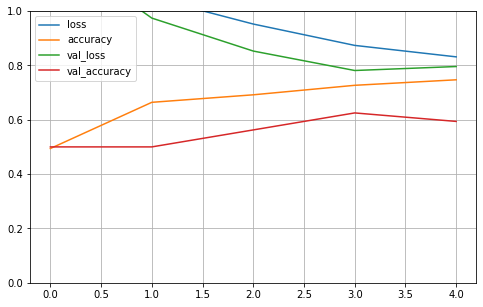

In [ ]:
model.save('/content/drive/MyDrive/dataset/model/MNIST.h5')   # always save your weights after training or during training
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
#disconnessione per non consumare risorse
from google.colab import runtime
runtime.unassign()

# **3. EFFICENT NET pre trained**

In [ ]:
# setup directory used in the project for training and test phase
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/dataset/OCT/'
train_dir = '/content/drive/MyDrive/dataset/OCT/train'
test_dir = '/content/drive/MyDrive/dataset/OCT/test'
val_dir = '/content/drive/MyDrive/dataset/OCT/val'

Mounted at /content/drive


In [ ]:
#Augmentation --> farlo con il layer

m_channels = 3
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb', #--> attenzione a questo valore , con efficentnet per forza rgb
    batch_size=64,
    image_size=(150, 150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

val = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb', #-> il modello non accetta 1 canale 
    batch_size=64,
    image_size=(150, 150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

# PER FARE L'AUGMENTATION
'''
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

img_dim = 150
batch_size=64
train_augmented = aug.flow_from_directory(
    directory=train_dir,
    target_size=(img_dim, img_dim),
    batch_size=batch_size ,
    shuffle=True,
    color_mode='rgb',
    seed=None,
    class_mode='categorical')

'''

UnknownError: ignored

In [ ]:
#usato per la normalizzazzione -> lo fa keras negli esempi -> velocizza il training
normalization_layer = tf.keras.layers.Rescaling(1./255)    
val = val.map(lambda x, y: (normalization_layer(x), y))
train = train.map(lambda x, y: (normalization_layer(x), y))


In [ ]:
# mantiene le immagini in memoria dopo che sono state caricate dal disco durante la prima epoca. Velocizza il training
#lo fa keras negli esempi
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Create Model
img_dim = 150
m_channels = 3
model_ENB0 = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(img_dim,img_dim,m_channels))
model_ENB0.trainable = False
CLASSES = 4
model = Sequential()
model.add(model_ENB0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(CLASSES,activation="softmax"))
model.summary()

### **OPTION 1 = Feature Reuse Training**

In [ ]:
#Early stopping -> sistemata
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=7,
    mode='auto',
    restore_best_weights=True)

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate=1e-2),
              metrics=['accuracy'])

# with augmentation 
# history = model.fit(train_augmented, epochs=5 , validation_data=val , verbose = 1 , callbacks=[early_stopping] , class_weight = class_weights)

# without augmentation 
history = model.fit(train, epochs=15 , validation_data=val ,steps_per_epoch=150, verbose = 1 , callbacks=[early_stopping] , class_weight = class_weights)


Epoch 1/15
150/150 [==============================] - 1155s 7s/step - loss: 1.6340 - accuracy: 0.3260 - val_loss: 1.6969 - val_accuracy: 0.2500
Epoch 2/15
150/150 [==============================] - 1062s 7s/step - loss: 1.6289 - accuracy: 0.3270 - val_loss: 1.7872 - val_accuracy: 0.2500
Epoch 3/15
150/150 [==============================] - 1060s 7s/step - loss: 1.6124 - accuracy: 0.3326 - val_loss: 1.6753 - val_accuracy: 0.2500
Epoch 4/15
  9/150 [>.............................] - ETA: 16:06 - loss: 1.6182 - accuracy: 0.3524

KeyboardInterrupt: ignored

In [ ]:
#evaluation with history
model.save('/content/drive/MyDrive/model/efficent_featurereuse.h5')   # always save your weights after training or during training
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
#disconnessione per non sprecare risorse
from google.colab import runtime
runtime.unassign()

### **OPTION 2 = fine tuning training**

In [ ]:
# Freezing all layers until the fifth from the last
model_ENB0.trainable = True
for layer in model_ENB0.layers[:-5]:
 layer.trainable = False

 
# model_ENB0.summary()

In [ ]:
#Early stopping -> sistemata
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=7,
    mode='auto',
    restore_best_weights=True)




# Pre Training
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate=1e-2),
              metrics=['accuracy'])
 
# epochs = 20  # @param {type: "slider", min:10, max:100}

#history = model.fit(train_augmented, epochs=epochs ,steps_per_epoch=100, validation_data=val , verbose = 1 , callbacks=[early_stopping] , class_weight = class_weights)
history = model.fit(train, epochs=epochs ,steps_per_epoch=100, validation_data=val , verbose = 1 , callbacks=[early_stopping] , class_weight = class_weights)

Epoch 1/20
100/100 [==============================] - 1766s 18s/step - loss: 1.6115 - accuracy: 0.3122 - val_loss: 8.1276 - val_accuracy: 0.2500
Epoch 2/20
  2/100 [..............................] - ETA: 40:16 - loss: 1.5369 - accuracy: 0.3125

In [ ]:
#evaluation with history
model.save('/content/drive/MyDrive/model/efficent_finetuning.h5')   # always save your weights after training or during training
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
#disconnessione per non sprecare risorse
from google.colab import runtime
runtime.unassign()

# **4. INCEPTION V3 pre-trained**

[esempio](https://github.com/tejanirla/image_classification/blob/master/transfer_learning.ipynb)

In [ ]:
# setup directory used in the project for training and test phase
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/dataset/OCT/'
train_dir = '/content/drive/MyDrive/dataset/OCT/train'
test_dir = '/content/drive/MyDrive/dataset/OCT/test'
val_dir = '/content/drive/MyDrive/dataset/OCT/val'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Augmentation --> farlo con il layer

m_channels = 3
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb', #--> attenzione a questo valore , con efficentnet per forza rgb
    batch_size=64,
    image_size=(150, 150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

val = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=64,
    image_size=(150, 150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

'''

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

img_dim = 150
batch_size=64
train_augmented = aug.flow_from_directory(
    directory=train_dir,
    target_size=(img_dim, img_dim),
    batch_size=batch_size ,
    shuffle=True,
    color_mode='rgb',
    seed=None,
    class_mode='categorical')

'''


Found 83493 files belonging to 4 classes.
Found 32 files belonging to 4 classes.


'\n\naug = ImageDataGenerator(\n    rotation_range=10,\n    zoom_range=0.15,\n    width_shift_range=0.1,\n    height_shift_range=0.1,\n    shear_range=0.15,\n    horizontal_flip=False,\n    vertical_flip=False,\n    fill_mode="nearest")\n\nimg_dim = 150\nbatch_size=64\ntrain_augmented = aug.flow_from_directory(\n    directory=train_dir,\n    target_size=(img_dim, img_dim),\n    batch_size=batch_size ,\n    shuffle=True,\n    color_mode=\'rgb\',\n    seed=None,\n    class_mode=\'categorical\')\n\n'

In [ ]:
#usato per la normalizzazzione -> lo fa keras negli esempi -> velocizza il training
normalization_layer = tf.keras.layers.Rescaling(1./255)    
val = val.map(lambda x, y: (normalization_layer(x), y))
train = train.map(lambda x, y: (normalization_layer(x), y))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
# mantiene le immagini in memoria dopo che sono state caricate dal disco durante la prima epoca. Velocizza il training
#lo fa keras negli esempi
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
#Early stopping -> sistemata
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=7,
    mode='auto',
    restore_best_weights=True)

### **Feature reuse**

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers


# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (4, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

adam = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer = adam, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:


history = model.fit(
            train,
            validation_data = val,
            steps_per_epoch = 400,
            epochs = 20,
            verbose = 1,
            callbacks=[early_stopping])


Epoch 1/20
400/400 [==============================] - 3035s 7s/step - loss: 10.5843 - accuracy: 0.7229 - val_loss: 0.7223 - val_accuracy: 0.5938
Epoch 2/20
400/400 [==============================] - 2436s 6s/step - loss: 0.6352 - accuracy: 0.7633 - val_loss: 0.5448 - val_accuracy: 0.8125
Epoch 3/20
400/400 [==============================] - 1823s 5s/step - loss: 0.6544 - accuracy: 0.7573 - val_loss: 0.6167 - val_accuracy: 0.6562
Epoch 4/20
105/400 [======>.......................] - ETA: 21:54 - loss: 0.8517 - accuracy: 0.7076

400/400 [==============================] - 470s 1s/step - loss: 0.8517 - accuracy: 0.7076 - val_loss: 0.9012 - val_accuracy: 0.5000


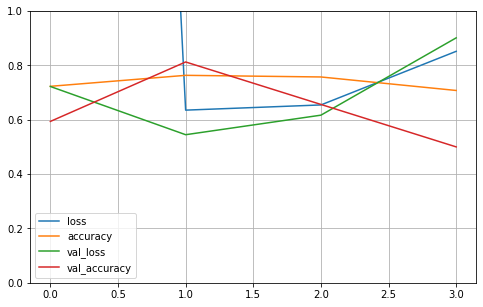

In [ ]:
import matplotlib.pyplot as plt
model.save('/content/drive/MyDrive/model/inceptionv3_featurereuse400step.h5')   # always save your weights after training or during training

#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### **Fine Tuning** 

In [ ]:
#unfreeze last layer
last_layer = pre_trained_model.get_layer('mixed7') #Only use layers including and above 'mixed7'
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (4, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

last layer output shape:  (None, 7, 7, 768)


In [ ]:


history = model.fit(
            train,
            validation_data = val,
            steps_per_epoch = 100,
            epochs = 23,
            validation_steps = 50,
            verbose = 2,
            callbacks=[early_stopping])

Epoch 1/23


In [ ]:
import matplotlib.pyplot as plt
model.save('/content/drive/MyDrive/model/inceptionv3_finetuning.h5')   # always save your weights after training or during training

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **5. NEURAL NET from scratch - PROVA GIUSEPPE**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from PIL import Image
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# setup directory used in the project for training and test phase
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/dataset/OCT/'
train_dir = '/content/drive/MyDrive/dataset/OCT/train'
test_dir = '/content/drive/MyDrive/dataset/OCT/test'
val_dir = '/content/drive/MyDrive/dataset/OCT/val'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# sarebbe l'augmentation
image_gen = ImageDataGenerator(rotation_range=25,
                              width_shift_range=0.1,
                              height_shift_range=0.1,rescale=1/255,shear_range=0.2,
                              zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')

In [ ]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(4, activation='softmax'))

optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 64)      640       
                                                                 
 batch_normalization_12 (Bat  (None, 148, 148, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 batch_normalization_13 (Bat  (None, 72, 72, 128)      512       
 chNormalization)                                                
                                                      

In [ ]:
training_image_aug =image_gen.flow_from_directory(train_dir , target_size=(150,150),batch_size=64 , color_mode='grayscale')
val_image_aug =image_gen.flow_from_directory(val_dir , target_size=(150,150),batch_size=64, color_mode='grayscale')

Found 83493 images belonging to 4 classes.


prova con gray scale e meno augmentation

In [ ]:
image_gen = ImageDataGenerator(rescale=1/255,shear_range=0,
                              zoom_range=0,horizontal_flip=False,fill_mode='nearest')
training_image_aug =image_gen.flow_from_directory(train_dir , target_size=(150,150),batch_size=64 , color_mode='grayscale')
val_image_aug =image_gen.flow_from_directory(val_dir , target_size=(150,150),batch_size=64, color_mode='grayscale')

Found 83493 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


In [ ]:
#Early stopping -> sistemata
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=7,
    mode='auto',
    restore_best_weights=True)
history = model.fit(training_image,
                              steps_per_epoch=200,
                              epochs=20,
                              validation_data=val_image,
                              callbacks=[early_stopping]
                              )

Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/MyDrive/model/Scrath3.h5')   # always save your weights after training or during training
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# **STOP - EXECUTE ALWAYS**

In [ ]:
from google.colab import runtime
runtime.unassign()

# **Analisi risultati migliori su kaggle**



1.   vgg16 - train 89%   [link](https://www.kaggle.com/code/carloalbertobarbano/vgg16-transfer-learning-pytorch)

2.    vgg16 - train 91%  &  inceptionv3 - train 92 [link](https://www.kaggle.com/code/paultimothymooney/detect-retina-damage-from-oct-images)

3.  custom - train 97% [link](https://www.kaggle.com/code/chir0313/oct-retinal-damage-prediction-99-accuracy)

4. resnet - train 99% [ link](https://www.kaggle.com/code/rashaadmeyer/retinal-oct-pytorch-99-8-resnet18)



## Prova 3. CUSTOM

In [ ]:
# setup directory used in the project for training and test phase
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/dataset/OCT/'
train_dir = '/content/drive/MyDrive/dataset/OCT/train'
test_dir = '/content/drive/MyDrive/dataset/OCT/test'
val_dir = '/content/drive/MyDrive/dataset/OCT/val'

In [ ]:
#Augmentation --> farlo con il layer

m_channels = 3
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale', #--> attenzione a questo valore , con efficentnet per forza rgb
    batch_size=64,
    image_size=(150, 150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

val = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=64,
    image_size=(150, 150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)



Found 83493 files belonging to 4 classes.
Found 32 files belonging to 4 classes.


In [ ]:
#usato per la normalizzazzione -> lo fa keras negli esempi -> velocizza il training
normalization_layer = tf.keras.layers.Rescaling(1./255)    
val = val.map(lambda x, y: (normalization_layer(x), y))
train = train.map(lambda x, y: (normalization_layer(x), y))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
from keras.layers.convolutional import Conv2D,MaxPooling2D

#creo il modello
def model():
  filters=60
  sizeoffilter1 = (5,5)
  sizeoffilter2 = (4,4)
  sizeoffilter3 = (3,3)
  sizeofpool = (2,2)
  node=5000

  model = Sequential();
  model.add((Conv2D(filters,sizeoffilter1,input_shape=(150,150,1)
  ,activation="relu")))

  model.add((Conv2D(filters,sizeoffilter1,activation="relu")))
  model.add((Conv2D(filters//2,sizeoffilter2,activation="relu")))
  model.add((Conv2D(filters//2,sizeoffilter2,activation="relu")))
  model.add(MaxPooling2D(pool_size=sizeofpool))
  model.add(Dropout(0.2))

  model.add((Conv2D(filters,sizeoffilter1,activation="relu")))
  model.add((Conv2D(filters//2,sizeoffilter2,activation="relu")))
  model.add((Conv2D(filters//2,sizeoffilter2,activation="relu")))
  model.add(MaxPooling2D(pool_size=sizeofpool))
  model.add(Dropout(0.2))

  model.add((Conv2D(filters,sizeoffilter2,activation="relu")))
  model.add(MaxPooling2D(pool_size=sizeofpool))
  model.add((Conv2D(filters//2,sizeoffilter3,activation="relu")))
  model.add((Conv2D(filters//2,sizeoffilter3,activation="relu")))
  model.add(MaxPooling2D(pool_size=sizeofpool))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(node,activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(4,activation="softmax"))

  model.compile(Adam(lr=0.001),loss="categorical_crossentropy",metrics=['accuracy'])

  return model
  
model=model()

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 146, 146, 60)      1560      
                                                                 
 conv2d_25 (Conv2D)          (None, 142, 142, 60)      90060     
                                                                 
 conv2d_26 (Conv2D)          (None, 139, 139, 30)      28830     
                                                                 
 conv2d_27 (Conv2D)          (None, 136, 136, 30)      14430     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 68, 68, 30)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 68, 68, 30)        0         
                                                      

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
#Early stopping -> sistemata
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=7,
    mode='auto',
    restore_best_weights=True)
#steps_per_epoch=150
history = model.fit(train,epochs=30,validation_data =val ,batch_size=256,
                    steps_per_epoch=150,
                    shuffle=True,
                    max_queue_size=20,
                    use_multiprocessing=True,
                    workers=1,
                    verbose = 1 ,
                   callbacks=[early_stopping] , 
                    class_weight = class_weights)

Epoch 1/30
  1/150 [..............................] - ETA: 1:54:49 - loss: 2.5559 - accuracy: 0.4219

KeyboardInterrupt: ignored

# **USE THE MODEL**

In [ ]:
#load the model
from keras.models import load_model
model = load_model('my_model.h5')

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer = adam, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])